In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay, make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# dataset from https://www.kaggle.com/datasets/xiaomengsun/car-insurance-claim-data/data
file_path = '/content/drive/MyDrive/Colab Notebooks/Data Bootcamp/Final Project/car_insurance_claim.csv'
df = pd.read_csv(file_path)
df.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,...,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,...,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,...,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,...,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,...,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


#### Basic Data Cleaning

In [7]:
# Create new copy of data
data = df.copy()

In [8]:
# Define updated column names for better clarity
col_names = {
    'KIDSDRIV': 'youth_drivers',
    'BIRTH': 'DOB',
    'AGE': 'age',
    'HOMEKIDS': 'num_of_children',
    'YOJ': 'years_on_job',
    'INCOME': 'income',
    'PARENT1': 'single_parent',
    'HOME_VAL': 'home_value',
    'MSTATUS': 'marital_status',
    'GENDER': 'gender',
    'EDUCATION': 'education_level',
    'OCCUPATION': 'occupation',
    'TRAVTIME': 'travel_time',
    'CAR_USE': 'type_of_use',
    'BLUEBOOK': 'vehicle_value',
    'TIF': 'time_in_force',
    'CAR_TYPE': 'vehicle_type',
    'RED_CAR': 'red_vehicle',
    'OLDCLAIM': '5yr_total_claims_value',
    'CLM_FREQ': '5yr_num_of_claims',
    'REVOKED': 'licence_revoked',
    'MVR_PTS': 'license_points',
    'CLM_AMT': 'new_claim_amount',
    'CAR_AGE': 'vehicle_age',
    'CLAIM_FLAG': 'claim_flag',
    'URBANICITY': 'area'
}

data.rename(columns=col_names, inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      10302 non-null  int64  
 1   youth_drivers           10302 non-null  int64  
 2   DOB                     10302 non-null  object 
 3   age                     10295 non-null  float64
 4   num_of_children         10302 non-null  int64  
 5   years_on_job            9754 non-null   float64
 6   income                  9732 non-null   object 
 7   single_parent           10302 non-null  object 
 8   home_value              9727 non-null   object 
 9   marital_status          10302 non-null  object 
 10  gender                  10302 non-null  object 
 11  education_level         10302 non-null  object 
 12  occupation              9637 non-null   object 
 13  travel_time             10302 non-null  int64  
 14  type_of_use             10302 non-null

In [10]:
data.drop_duplicates(inplace=True)

In [11]:
currency_cols = ['income', 'home_value', 'vehicle_value', '5yr_total_claims_value', 'new_claim_amount']

# Remove '$' and ',' from currency columns and convert to numeric
for col in currency_cols:
    data[col] = data[col].replace('[\\$,]', '', regex=True).astype('Int64')

In [12]:
z_cols = ['marital_status', 'gender', 'education_level', 'occupation', 'vehicle_type', 'area']

# Create function to remove 'z_' prefix
for col in z_cols:
    data[col] = data[col].replace('[z_]', '', regex=True)

In [13]:
# dropping unuseful features
data.drop(['ID', 'DOB'], axis=1, inplace=True)

In [14]:
data.head()

,youth_drivers,age,num_of_children,years_on_job,income,single_parent,home_value,marital_status,gender,education_level,...,vehicle_type,red_vehicle,5yr_total_claims_value,5yr_num_of_claims,licence_revoked,license_points,new_claim_amount,vehicle_age,claim_flag,area
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,...,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,...,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,...,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,...,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,...,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


In [15]:
data['claim_flag'].value_counts(normalize=True)
# checking for imbalance

,proportion
claim_flag,
0,0.733424
1,0.266576


In [16]:
# Drop target-dependent feature to avoid data leakage
X = data.drop(columns=['claim_flag', 'new_claim_amount'])
y = data['claim_flag']  # Target variable

### Exploratory Data Analysis

In [ ]:
data.describe()

,youth_drivers,age,num_of_children,years_on_job,income,home_value,travel_time,vehicle_value,time_in_force,5yr_total_claims_value,5yr_num_of_claims,license_points,new_claim_amount,vehicle_age,claim_flag
count,10301.000000,10294.000000,10301.000000,9753.000000,9731.0,9726.0,10301.000000,10301.0,10301.000000,10301.0,10301.000000,10301.000000,10301.0,9662.000000,10301.000000
mean,0.169304,44.837964,0.720513,10.473700,61568.83568,154513.740284,33.416853,15660.015532,5.329580,4034.369479,0.800796,1.710319,1511.413164,8.299524,0.266576
std,0.506533,8.606671,1.116355,4.108999,47458.566563,129191.840215,15.870398,8429.16922,4.110773,8733.476588,1.154108,2.159054,4725.455807,5.713361,0.442190
min,0.000000,16.000000,0.000000,0.000000,0.0,0.0,5.000000,1500.0,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,39.000000,0.000000,9.000000,27583.0,0.0,22.000000,9200.0,1.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000
50%,0.000000,45.000000,0.000000,11.000000,53526.0,160629.0,33.000000,14400.0,4.000000,0.0,0.000000,1.000000,0.0,8.000000,0.000000
75%,0.000000,51.000000,1.000000,13.000000,86139.5,238251.25,44.000000,20890.0,7.000000,4648.0,2.000000,3.000000,1145.0,12.000000,1.000000
max,4.000000,81.000000,5.000000,23.000000,367030.0,885282.0,142.000000,69740.0,25.000000,57037.0,5.000000,13.000000,123247.0,28.000000,1.000000


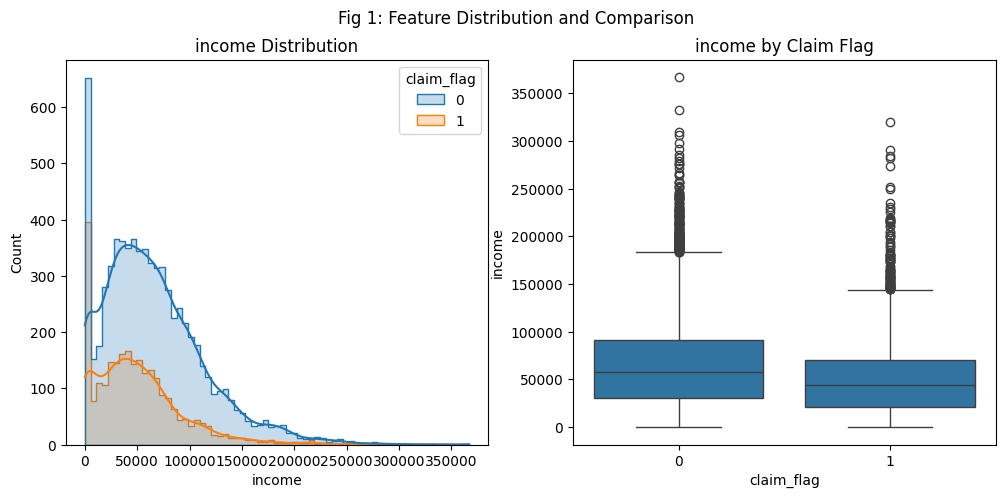

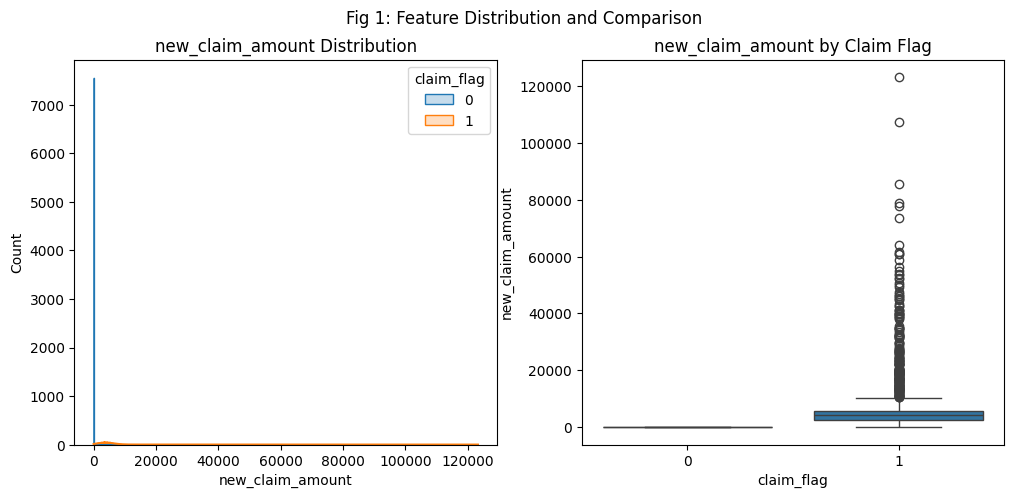

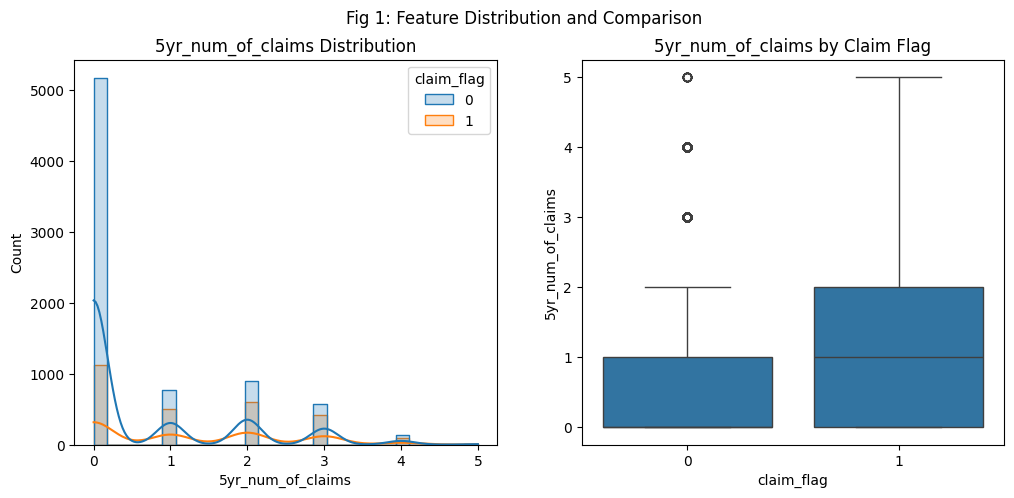

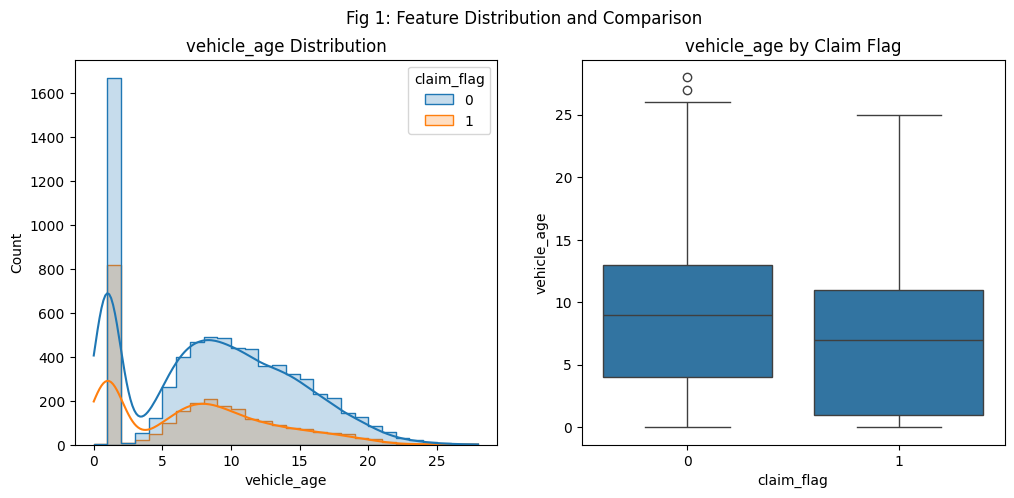

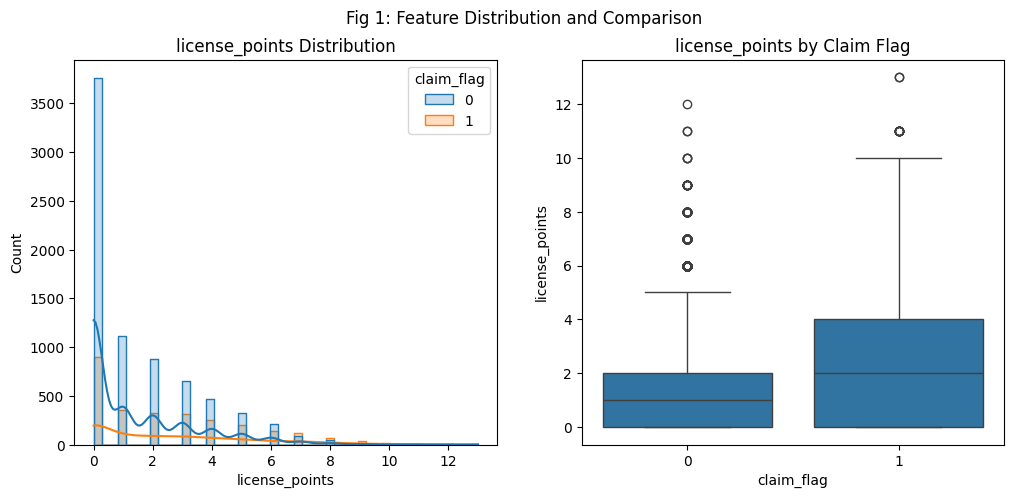

In [ ]:
dist_cols = ['income', 'new_claim_amount', '5yr_num_of_claims', 'vehicle_age', 'license_points']

# Plot distributions and boxplots for each numerical feature
for col in dist_cols:
    plt.figure(figsize=(12, 5))
    plt.suptitle("Fig 1: Feature Distribution and Comparison")

    # Histrogram plot
    plt.subplot(1, 2, 1)
    sns.histplot(data=data, x=col, kde=True, hue='claim_flag', element='step')
    plt.title(f'{col} Distribution')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=data, x='claim_flag', y=col)
    plt.title(f'{col} by Claim Flag')

In [17]:
eda_data = X.copy()
eda_data['claim_flag'] = y

In [19]:
binary_columns = ['single_parent', 'marital_status', 'gender', 'red_vehicle', 'licence_revoked']

# Map binary values in place
for col in binary_columns:
    eda_data[col] = eda_data[col].replace({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0, 'M': 1, 'F': 0})

In [20]:
eda_data.corr(numeric_only=True).sort_values(by='claim_flag',ascending=False)

,youth_drivers,age,num_of_children,years_on_job,income,single_parent,home_value,marital_status,gender,travel_time,vehicle_value,time_in_force,red_vehicle,5yr_total_claims_value,5yr_num_of_claims,licence_revoked,license_points,vehicle_age,claim_flag
claim_flag,0.108404,-0.107013,0.123015,-0.066216,-0.142552,0.158436,-0.185355,-0.129687,-0.021947,0.053268,-0.103295,-0.081293,-0.007297,0.142895,0.222586,0.155970,0.222449,-0.109745,1.000000
5yr_num_of_claims,0.038930,-0.037688,0.038619,-0.023476,-0.049175,0.061589,-0.093809,-0.070509,0.014075,0.008255,-0.042138,-0.017450,0.023504,0.494453,1.000000,0.055486,0.401381,-0.018794,0.222586
license_points,0.048400,-0.075788,0.064248,-0.041526,-0.063445,0.070114,-0.092409,-0.050839,-0.011029,0.009673,-0.044828,-0.031247,0.002758,0.262006,0.401381,0.050113,1.000000,-0.034049,0.222449
single_parent,0.200147,-0.311362,0.448707,-0.039196,-0.067137,1.000000,-0.250356,-0.474832,-0.068858,-0.015821,-0.049516,0.009004,-0.044446,0.039296,0.061589,0.050663,0.070114,-0.066384,0.158436
licence_revoked,0.033628,-0.045076,0.044159,-0.009921,-0.022909,0.050663,-0.044765,-0.040749,-0.011411,-0.002774,-0.028943,-0.031891,-0.009271,0.418200,0.055486,1.000000,0.050113,-0.019887,0.155970
5yr_total_claims_value,0.023872,-0.033409,0.029728,-0.005036,-0.039316,0.039296,-0.059772,-0.044582,-0.004107,-0.013819,-0.030731,-0.015569,0.006519,1.000000,0.494453,0.418200,0.262006,-0.018863,0.142895
num_of_children,0.463644,-0.447848,1.000000,0.077768,-0.160193,0.448707,-0.107442,0.046022,-0.113344,-0.000739,-0.108579,0.007444,-0.068028,0.029728,0.038619,0.044159,0.064248,-0.159205,0.123015
youth_drivers,1.000000,-0.078451,0.463644,0.043002,-0.043196,0.200147,-0.015424,0.041683,-0.039679,0.012198,-0.028512,-0.005865,-0.040463,0.023872,0.038930,0.033628,0.048400,-0.059724,0.108404
travel_time,0.012198,-0.001587,-0.000739,-0.017128,-0.051835,-0.015821,-0.035120,0.006032,-0.010510,1.000000,-0.022539,-0.013357,0.003521,-0.013819,0.008255,-0.002774,0.009673,-0.033249,0.053268
red_vehicle,-0.040463,0.025988,-0.068028,0.051804,0.066514,-0.044446,0.030472,-0.013929,0.663161,0.003521,0.026710,-0.006957,1.000000,0.006519,0.023504,-0.009271,0.002758,0.016869,-0.007297


Text(0.5, 1.0, 'Correlations with Claim Flag')

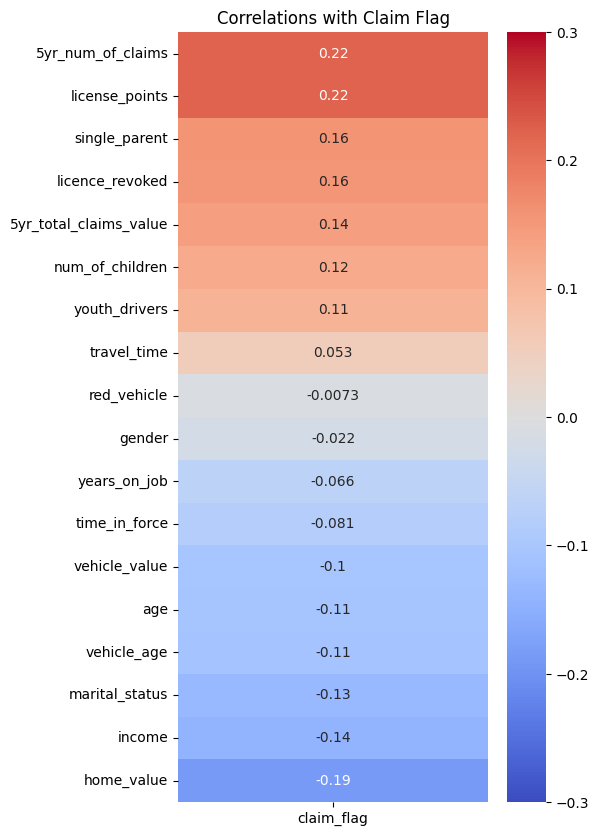

In [21]:
# Select all numeric columns, including binary columns
numeric_data = eda_data.select_dtypes(include=['number'])

# Compute correlations with claim_flag
correlations = numeric_data.corr()['claim_flag'].sort_values(ascending=False)
correlations_no_target = correlations.drop('claim_flag')

plt.figure(figsize=(5, 10))
sns.heatmap(correlations_no_target.to_frame(), annot=True, cmap='coolwarm', vmax=0.3, vmin=-0.3)
plt.title("Correlations with Claim Flag")

### Data Cleaning and Preprocessing

In [22]:
# drop features which showed next to no correlation with the target variable
X.drop(columns=['red_vehicle'], axis=1, inplace=True)

In [23]:
X.isnull().sum()

,0
youth_drivers,0
age,7
num_of_children,0
years_on_job,548
income,570
single_parent,0
home_value,575
marital_status,0
gender,0
education_level,0


In [24]:
# Handling missing numerical vals
num_missing_cols = ['years_on_job', 'income', 'home_value', 'vehicle_age']
for col in num_missing_cols:
    median_value = int(X[col].median())
    X[col].fillna(median_value, inplace=True)

# Handling missing categorical vals
cat_missing_cols = ['age', 'occupation']
for col in cat_missing_cols:
    mode_value = X[col].mode()[0]
    X[col].fillna(mode_value, inplace=True)

<ipython-input-24-60b37ed2965a>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(median_value, inplace=True)
<ipython-input-24-60b37ed2965a>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

#### Feature Encoding and Train-Test split

In [26]:
cat_cols = X.select_dtypes(include=['object']).columns  # Categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns  # Numerical columns

# Define imputers for missing values
num_imputer = SimpleImputer(strategy='median')  # Median for numerical
cat_imputer = SimpleImputer(strategy='most_frequent')  # Mode for categorical

# Preprocessing pipeline
preprocessor = make_column_transformer(
    # Categorical pipeline: impute -> one-hot encode
    (Pipeline([
        ('impute', cat_imputer),
        ('encode', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]), cat_cols),

    # Numerical pipeline: impute -> scale
    (Pipeline([
        ('impute', num_imputer),
        ('scale', StandardScaler())
    ]), num_cols),

    remainder='passthrough'
)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Modeling & Interpretations

### Baseline Model

In [28]:
# Predict majority class (all zeros) as a baseline
y_pred_baseline = [0] * len(y_test)

# Evaluate baseline
print("Baseline Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_baseline, zero_division=0):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_baseline):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_baseline):.2f}")

Baseline Model Performance:
Accuracy: 0.73
Precision: 0.00
Recall: 0.00
F1 Score: 0.00


### Model 1: Logistic Regression

In [30]:
lr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

In [31]:
lr_pipe.fit(X_train, y_train)
y_pred = lr_pipe.predict(X_test)

In [32]:
print("Logistic Regression Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Logistic Regression Model Performance:
Accuracy: 0.7986414361960213
Precision: 0.6914285714285714
Recall: 0.4408014571948998
F1 Score: 0.5383759733036707


### Model 2: Decision Tree

In [34]:
dt_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [35]:
dt_pipe.fit(X_train, y_train)
y_pred_dt = dt_pipe.predict(X_test)

In [36]:
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))

Accuracy: 0.710334788937409
Precision: 0.4566787003610108
Recall: 0.46083788706739526
F1 Score: 0.4587488667271079


### Model 3: Random Forest

In [37]:
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
])

In [38]:
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)

In [39]:
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))

Accuracy: 0.7908782144590005
Precision: 0.7169117647058824
Recall: 0.3551912568306011
F1 Score: 0.47503045066991473


### Model 4: XGBoost

In [41]:
xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

In [42]:
xgb_pipe.fit(X_train, y_train)
y_pred_xgb = xgb_pipe.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:50:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [43]:
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))

Accuracy: 0.7792333818534692
Precision: 0.6157635467980296
Recall: 0.4553734061930783
F1 Score: 0.5235602094240838


### Hyperparameter tuning

In [53]:
# Convert categorical columns to 'category' type
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Initialize XGBoost with enable_categorical
xgb_model = XGBClassifier(random_state=42, enable_categorical=True, eval_metric='logloss')

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Run GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_model,
                               param_grid=param_grid,
                               scoring=make_scorer(f1_score),
                               cv=3, verbose=1, n_jobs=-1)

grid_search_xgb.fit(X_train, y_train)

# Results
print("Best Parameters:", grid_search_xgb.best_params_)
print("Best F1 Score (Cross-Validation):", grid_search_xgb.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.7}
Best F1 Score (Cross-Validation): 0.5501720616870821


In [55]:
best_xgb = grid_search_xgb.best_estimator_

# Predict on the test set
y_pred_xgb_best = best_xgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_xgb_best))
print("Precision:", precision_score(y_test, y_pred_xgb_best))
print("Recall:", recall_score(y_test, y_pred_xgb_best))
print("F1 Score:", f1_score(y_test, y_pred_xgb_best))

Accuracy: 0.8064046579330422
Precision: 0.7094972067039106
Recall: 0.46265938069216755
F1 Score: 0.5600882028665931


Text(0.5, 1.0, 'Confusion Matrix - XGBoost')

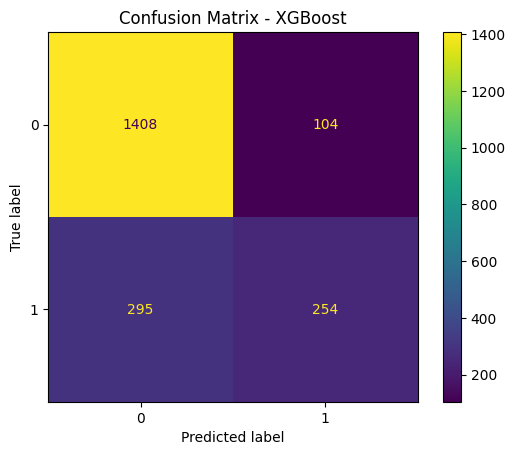

In [57]:
ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test, display_labels=[0, 1])
plt.title("Confusion Matrix - XGBoost")

Text(0.5, 1.0, 'Confusion Matrix - Logistic Regression')

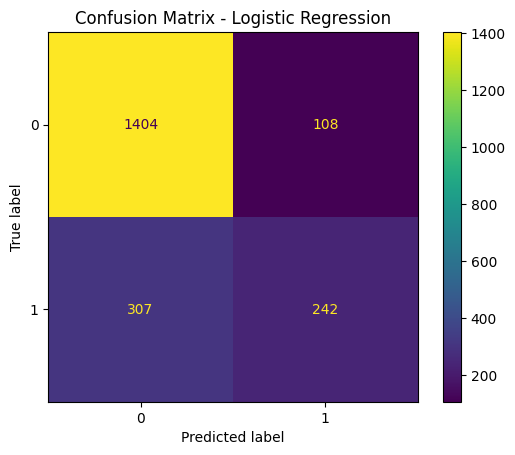

In [60]:
ConfusionMatrixDisplay.from_estimator(lr_pipe, X_test, y_test, display_labels=[0, 1])
plt.title("Confusion Matrix - Logistic Regression")